The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha1
!pip install -U mxnet-cu101==1.7.0


# Semantic Segmentation and the Dataset
:label:`sec_semantic_segmentation`

When discussing object detection tasks
in :numref:`sec_bbox`--:numref:`sec_rcnn`,
rectangular bounding boxes
are used to label and predict objects in images.
This section will discuss the problem of *semantic segmentation*,
which focuses on how to divide an image into regions belonging to different semantic classes.
Different from object detection,
semantic segmentation
recognizes and understands
what are in images in pixel level:
its labeling and prediction of semantic regions are
in pixel level.
:numref:`fig_segmentation` shows the labels
of the dog, cat, and background of the image in semantic segmentation.
Compared with in object detection,
the pixel-level borders labeled
in semantic segmentation are obviously more fine-grained.


![Labels of the dog, cat, and background of the image in semantic segmentation.](http://d2l.ai/_images/segmentation.svg)
:label:`fig_segmentation`


## Image Segmentation and Instance Segmentation

There are also two important tasks
in the field of computer vision that are similar to semantic segmentation,
namely image segmentation and instance segmentation.
We will briefly
distinguish them from semantic segmentation as follows.

* *Image segmentation* divides an image into several constituent regions. The methods for this type of problem usually make use of the correlation between pixels in the image. It does not need label information about image pixels during training, and it cannot guarantee that the segmented regions will have the semantics that we hope to obtain during prediction. Taking the image in :numref:`fig_segmentation` as input, image segmentation may divide the dog into two regions: one covers the mouth and eyes which are mainly black, and the other covers the rest of the body which is mainly yellow.
* *Instance segmentation* is also called *simultaneous detection and segmentation*. It studies how to recognize the pixel-level regions of each object instance in an image. Different from semantic segmentation, instance segmentation needs to distinguish not only semantics, but also different object instances. For example, if there are two dogs in the image, instance segmentation needs to distinguish which of the two dogs a pixel belongs to.



## The Pascal VOC2012 Semantic Segmentation Dataset

[**On of the most important semantic segmentation dataset
is [Pascal VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/).**]
In the following,
we will take a look at this dataset.


In [1]:
%matplotlib inline
import os
from mxnet import gluon, image, np, npx
from d2l import mxnet as d2l

npx.set_np()

The tar file of the dataset is about 2 GB,
so it may take a while to download the file.
The extracted dataset is located at `../data/VOCdevkit/VOC2012`.


In [2]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

After entering the path `../data/VOCdevkit/VOC2012`,
we can see the different components of the dataset.
The `ImageSets/Segmentation` path contains text files
that specify training and test samples,
while the `JPEGImages` and `SegmentationClass` paths
store the input image and label for each example, respectively.
The label here is also in the image format,
with the same size
as its labeled input image.
Besides,
pixels with the same color in any label image belong to the same semantic class.
The following defines the `read_voc_images` function to [**read all the input images and labels into the memory**].


In [3]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(image.imread(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(image.imread(os.path.join(
            voc_dir, 'SegmentationClass', f'{fname}.png')))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

We [**draw the first five input images and their labels**].
In the label images, white and black represent borders and  background, respectively, while the other colors correspond to different classes.


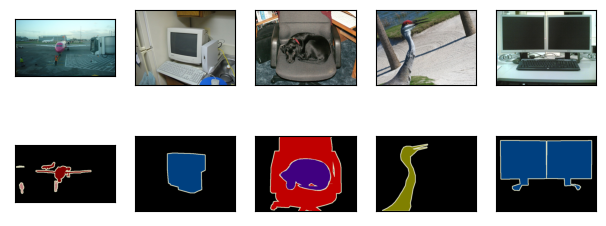

In [4]:
n = 5
imgs = train_features[:n] + train_labels[:n]
d2l.show_images(imgs, 2, n);

Next, we [**enumerate
the RGB color values and class names**]
for all the labels in this dataset.


In [5]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

With the two constants defined above,
we can conveniently
[**find the class index for each pixel in a label**].
We define the `voc_colormap2label` function
to build the mapping from the above RGB color values
to class indices,
and the `voc_label_indices` function
to map any RGB values to their class indices in this Pascal VOC2012 dataset.


In [6]:
#@save
def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = np.zeros(256 ** 3)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.astype(np.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

[**For example**], in the first example image,
the class index for the front part of the airplane is 1,
while the background index is 0.


In [7]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]]),
 'aeroplane')

### Data Preprocessing

In previous experiments
such as in :numref:`sec_alexnet`--:numref:`sec_googlenet`,
images are rescaled
to fit the model's required input shape.
However, in semantic segmentation,
doing so
requires rescaling the predicted pixel classes
back to the original shape of the input image.
Such rescaling may be inaccurate,
especially for segmented regions with different classes. To avoid this issue,
we crop the image to a *fixed* shape instead of rescaling. Specifically, [**using random cropping from image augmentation, we crop the same area of
the input image and the label**].


In [8]:
#@save
def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

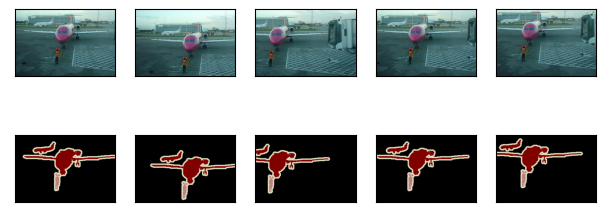

In [9]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

### [**Custom Semantic Segmentation Dataset Class**]

We define a custom semantic segmentation dataset class `VOCSegDataset` by inheriting the `Dataset` class provided by high-level APIs.
By implementing the `__getitem__` function,
we can arbitrarily access the input image indexed as `idx` in the dataset and the class index of each pixel in this image.
Since some images in the dataset
have a smaller size
than the output size of random cropping,
these examples are filtered out
by a custom `filter` function.
In addition, we also
define the `normalize_image` function to
standardize the values of the three RGB channels of input images.


In [10]:
#@save
class VOCSegDataset(gluon.data.Dataset):
    """A customized dataset to load the VOC dataset."""
    def __init__(self, is_train, crop_size, voc_dir):
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature.transpose(2, 0, 1),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

### [**Reading the Dataset**]

We use the custom `VOCSegDatase`t class to
create instances of the training set and test set, respectively.
Suppose that
we specify that the output shape of randomly cropped images is $320\times 480$.
Below we can view the number of examples
that are retained in the training set and test set.


In [11]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples


read 1078 examples


Setting the batch size to 64,
we define the data iterator for the training set.
Let's print the shape of the first minibatch.
Different from in image classification or object detection, labels here are three-dimensional tensors.


In [12]:
batch_size = 64
train_iter = gluon.data.DataLoader(voc_train, batch_size, shuffle=True,
                                   last_batch='discard',
                                   num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


### [**Putting It All Together**]

Finally, we define the following `load_data_voc` function
to download and read the Pascal VOC2012 semantic segmentation dataset.
It returns data iterators for both the training and test datasets.


In [13]:
#@save
def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset."""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = gluon.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, last_batch='discard', num_workers=num_workers)
    test_iter = gluon.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        last_batch='discard', num_workers=num_workers)
    return train_iter, test_iter

## Summary

* Semantic segmentation recognizes and understands what are in an image in pixel level by dividing the image into regions belonging to different semantic classes.
* One of the most important semantic segmentation dataset is Pascal VOC2012.
* In semantic segmentation, since the input image and  label correspond one-to-one on the pixel, the input image is randomly cropped to a fixed shape rather than rescaled.


## Exercises

1. How can semantic segmentation be applied in autonomous vehicles and medical image diagnostics? Can you think of other applications?
1. Recall the descriptions of data augmentation in :numref:`sec_image_augmentation`. Which of the image augmentation methods used in image classification would be infeasible to be applied in semantic segmentation?


[Discussions](https://discuss.d2l.ai/t/375)
